In [1]:
import tensorflow as tf
import numpy as np
import os
import re
import pandas as pd

from fuzzywuzzy import fuzz
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
from pyemd import emd
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

In [2]:
data_path = "/Users/Rutherford/Desktop/data"
epsilon = 1e-4

binary_file = os.path.join(data_path,
                           'GoogleNews-vectors-negative300.bin')
w2v_dat = os.path.join(data_path,'embed.dat')
w2v_vocab = os.path.join(data_path,'embed.vocab')

# create word embeddings and mapping of vocabulary item to index
embeddings = np.memmap(w2v_dat, dtype=np.float64,
                            mode="r", shape=(3000000, 300))
with open(w2v_vocab) as f:
    vocab_list = map(lambda string: string.strip(), f.readlines())
vocab_dict = {w: i for i, w in enumerate(vocab_list)}

# mean of 20 rarest words, used as a stand-in for pairwise distances
# if a word is out-of-vocabulary
avg_rare_word = np.mean(np.vstack(embeddings[-20:]),axis=0)
bad_row = np.asarray([avg_rare_word])


In [3]:
def cos_getter(strings):
    s_1 = strings['one']
    s_2 = strings['two']
    

    # removed need for these by using cleaned_dataset as of 11/9
    s_1 = re.sub(r'-',' ',s_1)
    s_1 = re.sub(r"\ba\b",'one',s_1)

    s_2 = re.sub(r'-',' ',s_2)
    s_2 = re.sub(r"\ba\b",'one',s_2)

    
    s1_features = s_1.split()
    s2_features = s_2.split()

    # mean of word embeddings per string (0s if no items are in embeddings)
    # shape is [1,300] per string
    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])
    #results_.extend(S1_)
    #results_.extend(S2_)
    return cosine(S1_,S2_)


In [4]:
def WMD_cosine(strings):
    """Return counts of in-vocabulary and out-of-vocabulary items per
    string, means of embeddings per string, and Word Mover's Distance
    between the two. Word embeddings and mappings were created upon
    initialization of the class instance, and WMD with emd()
    (Earth Mover's Distance) from PyEMD. Final shape is [1,612].
    """
    
    s_1 = strings['one']
    s_2 = strings['two']

    #results_ = []

    ###############
    #s_1 = re.sub(r"\bs\d{0,2}\b",'speaker',s_1)
    #s_1 = re.sub(r"\b\d{5,6}\b",'timestamp',s_1)
    #s_1 = re.sub(r'\d+','digit',s_1)
    s_1 = re.sub(r'-',' ',s_1)
    s_1 = re.sub(r"\ba\b",'one',s_1)

    #s_2 = re.sub(r"\bs\d{0,2}\b",'speaker',s_2)
    #s_2 = re.sub(r"\b\d{5,6}\b",'timestamp',s_2)
    #s_2 = re.sub(r'\d+','digit',s_2)
    s_2 = re.sub(r'-',' ',s_2)
    s_2 = re.sub(r"\ba\b",'one',s_2)


    # moved this up here from mean of word embeddings section
    s1_features = s_1.split()
    s2_features = s_2.split()
    
    try:
        # fit CV on words with or without a single quote
        vect = CountVectorizer(token_pattern='[\w\']+').fit([s_1, s_2])
        features = np.asarray(vect.get_feature_names())
    except:
        return -1

    # get 'flow' vectors
    v_1, v_2 = vect.transform([s_1, s_2])
    v_1 = v_1.toarray().ravel().astype(np.float64)
    v_2 = v_2.toarray().ravel().astype(np.float64)

    # normalize vectors so as not to reward shorter strings in WMD
    v_1 /= (v_1.sum()+epsilon)
    v_2 /= (v_2.sum()+epsilon)

    # for each out-of-vocabulary item, use the average of the 20
    # rarest words' embeddings to represent it in the distance calc       
    W_ = np.ndarray([0,300])

    # get distance matrix for words in both strings
    for w in features:
        if w in vocab_dict:
            W_ = np.append(W_,embeddings[[vocab_dict[w]]],axis=0)
        else:
            W_ = np.append(W_,bad_row,axis=0)

    # use both euclidean and cosine dists (cosine dist is 1-cosine sim)
    #D_euclidean = euclidean_distances(W_).astype(np.float64)
    D_cosine = 1.-cosine_similarity(W_,).astype(np.float64)

    # using EMD (Earth Mover's Distance) from PyEMD
    #distances_euclidean = emd(v_1,v_2,D_euclidean)
    distances_cosine = emd(v_1,v_2,D_cosine)

    # both WMD calculations (euclidean and cosine)
    #results_.append(distances_euclidean)
    #results_.append(distances_cosine)

    return distances_cosine


In [5]:
def in_vocab(strings):

    s_1 = strings
    s1_features = s_1.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))

    #s_1_bad = sum(map(lambda word:word not in self.vocab_dict,s1_features))
    s_1_good = sum(map(lambda word:word in vocab_dict,s1_features))
    
    return s_1_good

In [6]:
def out_of_vocab(strings):

    s_1 = strings
    s1_features = s_1.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))

    s_1_bad = sum(map(lambda word:word not in vocab_dict,s1_features))
    #s_1_good = sum(map(lambda word:word in vocab_dict,s1_features))
    
    return s_1_bad
    

In [7]:
def euc_getter(strings):
    s_1 = strings['one']
    s_2 = strings['two']
    
    s_1 = re.sub(r'-',' ',s_1)
    s_1 = re.sub(r"\ba\b",'one',s_1)

    #s_2 = re.sub(r"\bs\d{0,2}\b",'speaker',s_2)
    #s_2 = re.sub(r"\b\d{5,6}\b",'timestamp',s_2)
    #s_2 = re.sub(r'\d+','digit',s_2)
    s_2 = re.sub(r'-',' ',s_2)
    s_2 = re.sub(r"\ba\b",'one',s_2)

    
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        


    # number of out-of-vocabulary and in-vocabulary items
    #s_1_bad = sum(map(lambda word:word not in self.vocab_dict,s1_features))
    #s_1_good = sum(map(lambda word:word in self.vocab_dict,s1_features))
    #s_2_bad = sum(map(lambda word:word not in self.vocab_dict,s2_features))
    #s_2_good = sum(map(lambda word:word in self.vocab_dict,s2_features))
    ###results_.append(s_1_bad)
    ###results_.append(s_1_good)
    ###results_.append(s_2_bad)
    ###results_.append(s_2_good)

    # mean of word embeddings per string (0s if no items are in embeddings)
    # shape is [1,300] per string
    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])
    #results_.extend(S1_)
    #results_.extend(S2_)
    return euclidean(S1_,S2_)


In [289]:
# this one is 86.9% the same as the other cosine metric
def sum_vector_cos_getter(strings):
    s_1 = strings['one']
    s_2 = strings['two']
    
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        

    # sum of word embeddings per string (small # epsilon if no items are in embeddings)
    # shape is [1,300] per string
    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.sum(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.sum(S2_,axis=0)).reshape([-1,1])
    #results_.extend(S1_)
    #results_.extend(S2_)
    return cosine(S1_,S2_)


cleaning_dataset is output from "dataset cleaning" notebook, and changes:
- underscores to nothing
> then removes observations with empty strings in either column
- dashes to spaces
- 'cause to because
- a to one


In [142]:
#training_set = '/Users/Rutherford/Desktop/data/dataset.csv'
training_set = '/Users/Rutherford/Desktop/cleaning_dataset.csv'

In [143]:
df = pd.read_csv(training_set,header=None,dtype={'error':np.int32,'one':str,'two':str},na_filter=False)
df.columns = ['error','one','two']
# if len(two) is zero, indicate that with a binary feature. maybe don't use lengths at all?

In [144]:
df['cosine'] = df.apply(cos_getter,axis=1)
df['len1'] = map(len,df['one'].values)
df['len2'] = map(len,df['two'].values)
df['wmd_cos'] = df[['one','two']].apply(WMD_cosine,axis=1)
df['error'].loc[df['len2']==0] = 1
df['s1_good'] = df['one'].apply(in_vocab)
df['s2_good'] = df['two'].apply(in_vocab)
df['s1_bad'] = df['one'].apply(out_of_vocab)
df['s2_bad'] = df['two'].apply(out_of_vocab)
df['euclidean'] = df[['one','two']].apply(euc_getter,axis=1)
df['wmd_norm'] = df['wmd_cos']-df['wmd_cos'].mean()
df['cos_norm'] = df['cosine']-df['cosine'].mean()
df['euc_norm'] = df['euclidean']-df['euclidean'].mean()

In [291]:
##df['cos_of_sum'] = df[['one','two']].apply(sum_vector_cos_getter,axis=1)
# not useful, as 86.9% of the dataset seems to have the same value 
# for the sum and mean of the word vectors per string

In [292]:
g1, g2 = df.groupby('error')

In [293]:
df.head()

,error,one,two,cosine,len1,len2,wmd_cos,s1_good,s2_good,s1_bad,s2_bad,euclidean,wmd_norm,cos_norm,euc_norm,wmd_times_cos,cos_of_sum
0,1,zone and,zone,0.000000e+00,8,4,4.175405e-01,1,1,1,0,0.000000,-0.084538,-0.408930,-1.672534,0.034570,0.000000e+00
1,2,zigbee 2,zigbee too,9.452572e-01,8,10,4.726050e-01,1,1,1,1,2.888256,-0.029473,0.536328,1.215722,-0.015807,9.452572e-01
2,2,zero,four zero,1.483317e-01,4,9,4.101423e-01,1,2,0,0,1.513861,-0.091936,-0.260598,-0.158673,0.023958,1.483317e-01
3,2,zappos is ideal,zappos' deal,8.932686e-01,15,12,5.938654e-01,2,1,1,1,2.928596,0.091787,0.484339,1.256063,0.044456,8.932686e-01
4,1,zapples,zappos,3.330669e-16,7,6,1.110112e-16,0,0,1,1,0.000000,-0.502078,-0.408930,-1.672534,0.205315,3.330669e-16


## Visualizing splits along certain features and interactions of features

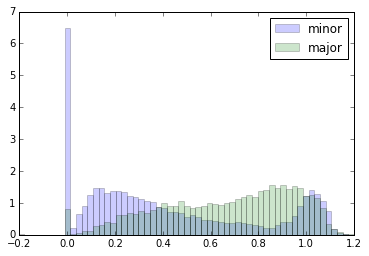

In [18]:
bins = np.linspace(-.2, 1.2, 60)
plt.hist(g1[1]['cosine'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['cosine'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

In [20]:
g1[1].iloc[(g1[1]['cosine']>.8).values]#&(g1[1]['cosine']<1.))

,error,one,two,cosine,len1,len2,wmd_cos,s1_good,s2_good,s1_bad,s2_bad,euclidean,wmd_norm,cos_norm,euc_norm
21,1,you,,1.083966,3,0,-2.220224e-16,1,0,0,0,2.326611,-0.502131,0.634994,0.732074
195,1,x,,0.996228,1,0,-2.220224e-16,1,0,0,0,2.708646,-0.502131,0.547255,1.114109
892,1,trying to,,0.944429,9,0,9.383879e-01,1,0,1,0,2.586670,0.436257,0.495456,0.992133
1269,1,themselves,,1.044751,10,0,2.220224e-16,1,0,0,0,2.523279,-0.502131,0.595779,0.928742
1457,1,tat,,0.979348,3,0,1.110112e-16,1,0,0,0,2.994201,-0.502131,0.530375,1.399664
1554,1,suffer,,1.070992,6,0,1.110112e-16,1,0,0,0,2.884658,-0.502131,0.622019,1.290121
1617,1,stories,,0.935720,7,0,1.110112e-16,1,0,0,0,2.873144,-0.502131,0.486748,1.278607
1667,1,statute,,0.956447,7,0,1.110112e-16,1,0,0,0,3.586507,-0.502131,0.507475,1.991970
1845,1,sorry the echo chuckle is distracting me a lit...,,0.958926,53,0,1.034731e+00,9,0,1,0,1.242916,0.532600,0.509954,-0.351621
2068,1,sign,,0.983389,4,0,-2.220224e-16,1,0,0,0,2.545611,-0.502131,0.534416,0.951075


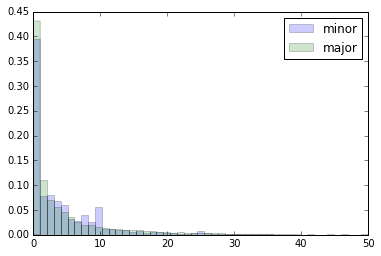

In [21]:
fig = plt.figure()
bins = np.linspace(0, 50, 50)
plt.hist(g1[1]['len2']-g1[1]['len1'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['len2']-g2[1]['len1'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

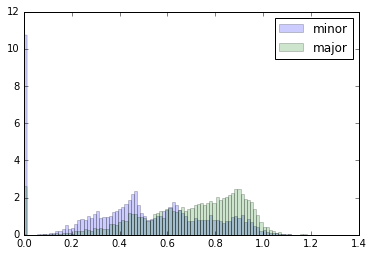

In [22]:
bins = np.linspace(0,1.3,100)
plt.hist(g1[1]['wmd_cos'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_cos'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

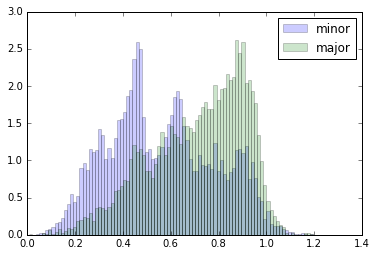

In [23]:
bins = np.linspace(0.01,1.3,100)
plt.hist(g1[1]['wmd_cos'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_cos'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

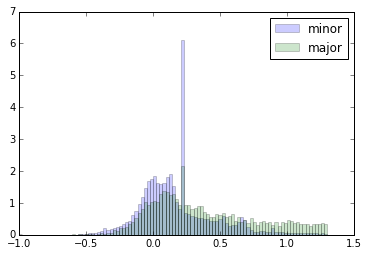

In [24]:
#added this tuesday 11/8
bins = np.linspace(-1,1.3,100)
plt.hist(g1[1]['wmd_norm']+(g1[1]['euc_norm']*g1[1]['cos_norm']),bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_norm']+(g2[1]['euc_norm']*g2[1]['cos_norm']),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

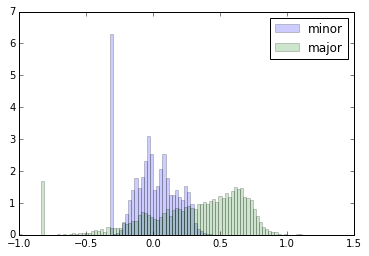

In [25]:
#added this tuesday 11/8
bins = np.linspace(-1,1.3,100)
plt.hist(g1[1]['wmd_norm']*g1[1]['cosine'].mean()*g1[1]['euclidean'].mean(),bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_norm']*g2[1]['cosine'].mean()*g2[1]['euclidean'].mean(),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

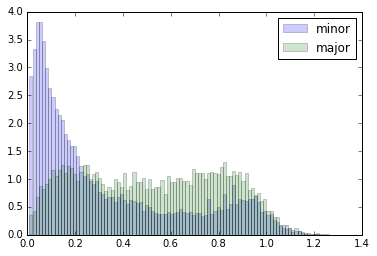

In [26]:
#this is a little interesting
bins = np.linspace(0.01,1.3,100)
plt.hist(g1[1]['wmd_cos']*g1[1]['cosine'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_cos']*g2[1]['cosine'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

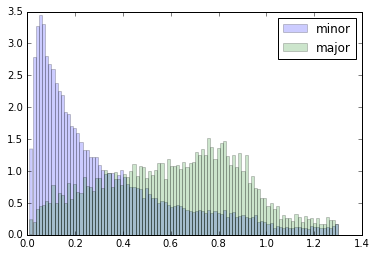

In [27]:
bins = np.linspace(0.01,1.3,100)
plt.hist(g1[1]['cosine']*g1[1]['s2_good']*g1[1]['wmd_cos'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['cosine']*g2[1]['s2_good']*g2[1]['wmd_cos'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

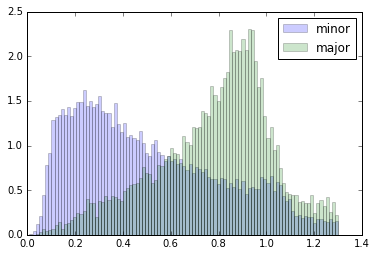

In [28]:
bins = np.linspace(0.01,1.3,100)
plt.hist(g1[1]['cosine']*g1[1]['s2_good'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['cosine']*g2[1]['s2_good'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

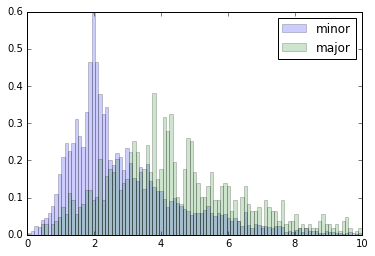

In [29]:
bins = np.linspace(0.01,10,100)
plt.hist((g1[1]['cosine']+g1[1]['euclidean'])*(g1[1]['s2_good']/(g1[1]['s1_bad']+epsilon)),bins,alpha=.2,label='minor',normed=True)
plt.hist((g2[1]['cosine']+g2[1]['euclidean'])*(g2[1]['s2_good']/(g2[1]['s1_bad']+epsilon)),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

### using random forest to benchmark/make use of features with better splits

In [31]:
rf = RandomForestClassifier()

In [32]:
df.columns

Index([u'error', u'one', u'two', u'cosine', u'len1', u'len2', u'wmd_cos',
       u's1_good', u's2_good', u's1_bad', u's2_bad', u'euclidean', u'wmd_norm',
       u'cos_norm', u'euc_norm'],
      dtype='object')

In [ ]:
# things that didn't do much

# this was before removing empty string rows entirely
#df['to_nothing'] = 0
#df['to_nothing'].ix[df.loc[df['len2']==0].index.values.tolist()]=1

#df2=df.loc[df['wmd_cos']!=0]

In [340]:
# what do these have in common?
# get rid of these and many FNs go away

# many of these do seem to be minors
g2[1].loc[g2[1]['wmd_cos']<.51]#.ix[7500:]

,error,one,two,cosine,len1,len2,wmd_cos,s1_good,s2_good,s1_bad,s2_bad,euclidean,wmd_norm,cos_norm,euc_norm,wmd_times_cos,cos_of_sum
1,2,zigbee 2,zigbee too,0.945257,8,10,0.472605,1,1,1,1,2.888256,-0.029473,0.536328,1.215722,-0.015807,0.945257
2,2,zero,four zero,0.148332,4,9,0.410142,1,2,0,0,1.513861,-0.091936,-0.260598,-0.158673,0.023958,0.148332
9,2,you,you that,0.092797,3,8,0.371206,1,2,0,0,1.173538,-0.130872,-0.316132,-0.498996,0.041373,0.092797
10,2,you,you simply,0.125653,4,10,0.312560,1,2,0,0,1.173175,-0.189518,-0.283276,-0.499358,0.053686,0.125653
14,2,you,your,0.219109,3,5,0.219087,1,1,0,0,1.806976,-0.282991,-0.189820,0.134442,0.053717,0.219109
15,2,you,you it,0.093843,3,6,0.289060,1,2,0,0,1.089730,-0.213018,-0.315087,-0.582804,0.067119,0.093843
17,2,you,you about that,0.226100,3,14,0.501824,1,3,0,0,1.542624,-0.000254,-0.182829,-0.129910,0.000046,0.226100
23,2,you would,so you,0.175357,9,6,0.328105,2,2,0,0,0.997738,-0.173973,-0.233573,-0.674796,0.040636,0.175357
24,2,you won,you one,0.364324,7,7,0.432210,2,2,0,0,1.465384,-0.069868,-0.044606,-0.207149,0.003117,0.364324
27,2,you we're,you're,0.328998,9,6,0.440721,2,1,0,0,2.188699,-0.061357,-0.079931,0.516165,0.004904,0.328998


In [35]:
# 'cause, 'bout, 'til
# blank to something
# short, related but opposite
# numbers that are different

In [36]:
vocab_dict["til"]

31231

In [37]:
g2[1].loc[g2[1]['len1']==0].shape

(625, 15)

In [40]:
g1[1].loc[g1[1]['len1']==0].shape

(2681, 15)

In [41]:
X = df[['cosine','euclidean','len1','len2','wmd_cos']]
y = df['error']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
rf.score(X_test,y_test)

0.89734736157939632

## Trying to identify problematic areas like mislabeled observations
### and, you know, label them properly

In [33]:
from sklearn.cluster import DBSCAN,KMeans

## DBscan

In [13]:
db = DBSCAN()

In [32]:
np.where(db.fit_predict(g1[1][['cosine','wmd_cos','euclidean']].values[:10000])!=0)

(array([3444]),)

In [34]:
#df.ix[np.where(db.fit_predict(g1[1][['cosine','wmd_cos']].values[:10])==-1)[0]]

## Kmeans

In [147]:
km = KMeans()

In [148]:
km.fit_predict(g2[1][['cosine','wmd_cos','euclidean']].values)

array([6, 1, 2, ..., 2, 6, 5], dtype=int32)

In [149]:
df_1s = pd.DataFrame(g1[1])
df_2s = pd.DataFrame(g2[1])

In [150]:
df_2s['cluster'] = km.fit_predict(g2[1][['cosine','wmd_cos','euclidean']].values)

In [151]:
np.unique(df_2s['cluster'])

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [152]:
maj0,maj1,maj2,maj3,maj4,maj5,maj6,maj7 = df_2s.groupby('cluster')

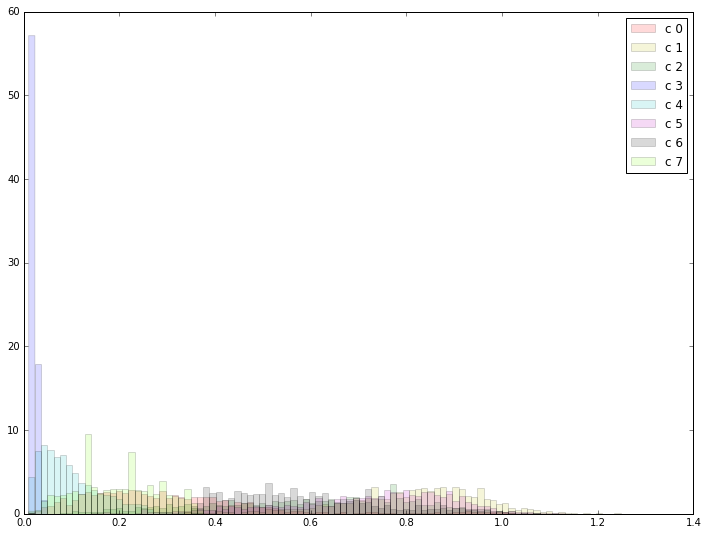

In [153]:
plt.figure(figsize=(12,9))
bins = np.linspace(0.01,1.3,100)

plt.hist(maj0[1]['cosine']*maj0[1]['wmd_cos'],bins,alpha=.15,label='c 0',normed=True,color='r')
plt.hist(maj1[1]['cosine']*maj1[1]['wmd_cos'],bins,alpha=.15,label='c 1',normed=True,color='y')
plt.hist(maj2[1]['cosine']*maj2[1]['wmd_cos'],bins,alpha=.15,label='c 2',normed=True,color='g')
plt.hist(maj3[1]['cosine']*maj3[1]['wmd_cos'],bins,alpha=.15,label='c 3',normed=True,color='b')
plt.hist(maj4[1]['cosine']*maj4[1]['wmd_cos'],bins,alpha=.15,label='c 4',normed=True,color='c')
plt.hist(maj5[1]['cosine']*maj5[1]['wmd_cos'],bins,alpha=.15,label='c 5',normed=True,color='m')
plt.hist(maj6[1]['cosine']*maj6[1]['wmd_cos'],bins,alpha=.15,label='c 6',normed=True,color='k')
plt.hist(maj7[1]['cosine']*maj7[1]['wmd_cos'],bins,alpha=.15,label='c 7',normed=True,color='chartreuse')


plt.legend(loc='upper right')
plt.show()

In [168]:
# reclassifying purple cluster
twos_that_should_be_ones = df_2s[(df_2s['cluster'] == 3)].index.values
df.loc[twos_that_should_be_ones,'error']=1

In [244]:
# groupby again with new error class
g1, g2 = df.groupby('error')

In [ ]:
# didn't see big improvements
# using same rf as above -- 0.78498250347822418 and worse with more features
# think about the recipe of combined features to use

In [245]:
km = KMeans()
df_1s = pd.DataFrame(g1[1])
df_2s = pd.DataFrame(g2[1])
df_2s['cluster'] = km.fit_predict(g2[1][['cosine','wmd_cos','euclidean']].values)
np.unique(df_2s['cluster'])

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [246]:
maj0,maj1,maj2,maj3,maj4,maj5,maj6,maj7 = df_2s.groupby('cluster')

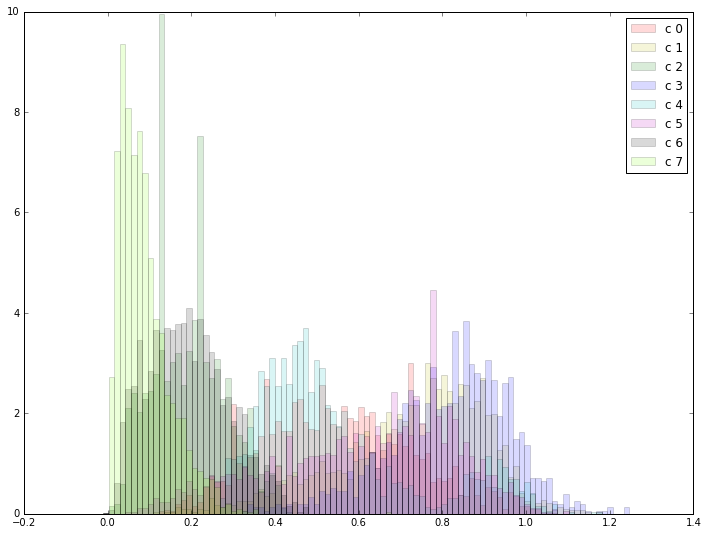

In [252]:
plt.figure(figsize=(12,9))
bins = np.linspace(-.01,1.3,100)

plt.hist(maj0[1]['cosine']*maj0[1]['wmd_cos'],bins,alpha=.15,label='c 0',normed=True,color='r')
plt.hist(maj1[1]['cosine']*maj1[1]['wmd_cos'],bins,alpha=.15,label='c 1',normed=True,color='y')
plt.hist(maj2[1]['cosine']*maj2[1]['wmd_cos'],bins,alpha=.15,label='c 2',normed=True,color='g')
plt.hist(maj3[1]['cosine']*maj3[1]['wmd_cos'],bins,alpha=.15,label='c 3',normed=True,color='b')
plt.hist(maj4[1]['cosine']*maj4[1]['wmd_cos'],bins,alpha=.15,label='c 4',normed=True,color='c')
plt.hist(maj5[1]['cosine']*maj5[1]['wmd_cos'],bins,alpha=.15,label='c 5',normed=True,color='m')
plt.hist(maj6[1]['cosine']*maj6[1]['wmd_cos'],bins,alpha=.15,label='c 6',normed=True,color='k')
plt.hist(maj7[1]['cosine']*maj7[1]['wmd_cos'],bins,alpha=.15,label='c 7',normed=True,color='chartreuse')


plt.legend(loc='upper right')
plt.show()

In [243]:
#df_2s[(df_2s['cluster'] == 7)][['one','two']]

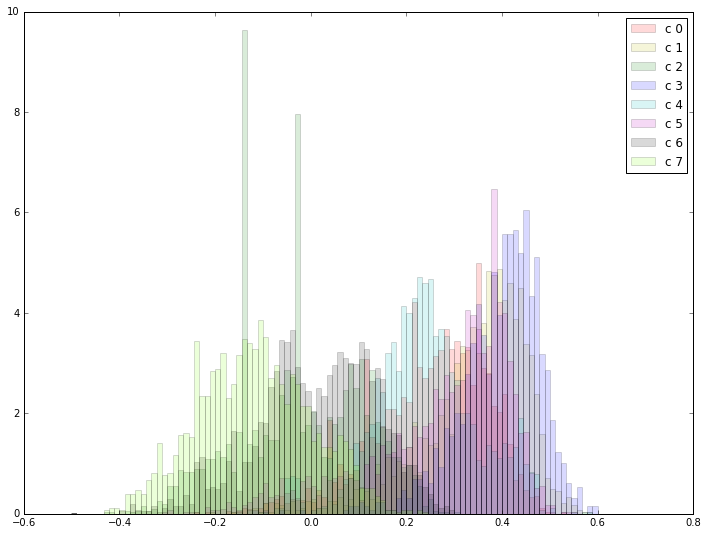

In [255]:
plt.figure(figsize=(12,9))
bins = np.linspace(-.5,.6,100)

plt.hist(maj0[1]['wmd_norm'],bins,alpha=.15,label='c 0',normed=True,color='r')
plt.hist(maj1[1]['wmd_norm'],bins,alpha=.15,label='c 1',normed=True,color='y')
plt.hist(maj2[1]['wmd_norm'],bins,alpha=.15,label='c 2',normed=True,color='g')
plt.hist(maj3[1]['wmd_norm'],bins,alpha=.15,label='c 3',normed=True,color='b')
plt.hist(maj4[1]['wmd_norm'],bins,alpha=.15,label='c 4',normed=True,color='c')
plt.hist(maj5[1]['wmd_norm'],bins,alpha=.15,label='c 5',normed=True,color='m')
plt.hist(maj6[1]['wmd_norm'],bins,alpha=.15,label='c 6',normed=True,color='k')
plt.hist(maj7[1]['wmd_norm'],bins,alpha=.15,label='c 7',normed=True,color='chartreuse')


plt.legend(loc='upper right')
plt.show()

### looking at minors now

In [276]:
km = KMeans(n_clusters=4)
df_1s['cluster'] = km.fit_predict(g1[1][['cosine','wmd_cos']].values)
np.unique(df_1s['cluster'])

array([0, 1, 2, 3], dtype=int32)

In [277]:
min0,min1,min2,min3 = df_1s.groupby('cluster')

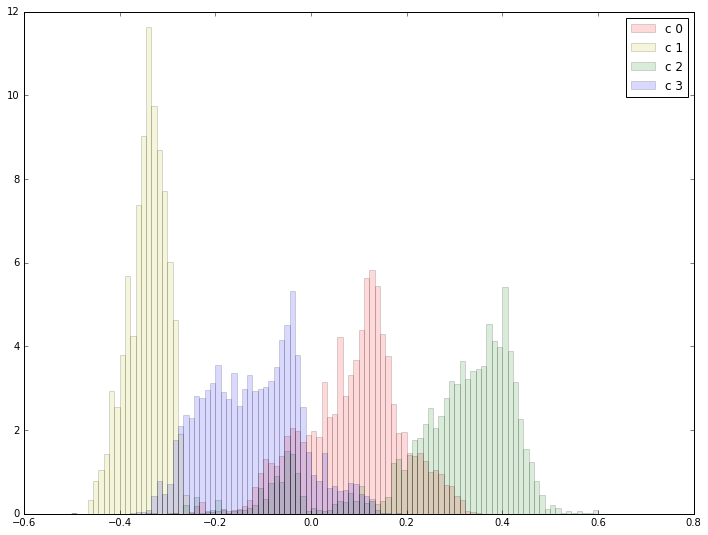

In [341]:
plt.figure(figsize=(12,9))
bins = np.linspace(-.5,.6,100)

plt.hist(min0[1]['wmd_norm'],bins,alpha=.15,label='c 0',normed=True,color='r')
plt.hist(min1[1]['wmd_norm'],bins,alpha=.15,label='c 1',normed=True,color='y')
plt.hist(min2[1]['wmd_norm'],bins,alpha=.15,label='c 2',normed=True,color='g')
plt.hist(min3[1]['wmd_norm'],bins,alpha=.15,label='c 3',normed=True,color='b')

plt.legend(loc='upper right')
plt.show()

In [599]:
#min2[1]

In [345]:
vocab_dict['yup']

117309

In [739]:
# a number of these are in fact major
df_1s[df_1s['cluster']==2].shape

(9052, 18)

In [348]:
# these are pretty much the pure minors, tried and true
#df_1s[df_1s['cluster']==1]

#### not all of cluster two is major, but quite a few. is there some way to split within that?

In [741]:
df_1s[(df_1s['cluster']==2) & (df_1s['wmd_norm']<.4)]

,error,one,two,cosine,len1,len2,wmd_cos,s1_good,s2_good,s1_bad,s2_bad,euclidean,wmd_norm,cos_norm,euc_norm,wmd_times_cos,cluster,good_bad_cluster
16433,1,zos and,zo's amy,0.996970,7,8,0.396366,0,1,2,1,2.772609,-0.105712,0.588040,1.100075,-0.062163,2,0
16437,1,zoey,zoe,0.990311,4,3,0.771498,0,1,1,0,1.918899,0.269420,0.581382,0.246365,0.156636,2,0
16440,1,zo beck,zoubeck,1.026438,7,7,0.805117,2,0,0,1,2.309273,0.303039,0.617508,0.636739,0.187129,2,0
16441,1,z net,zdnet,0.790663,5,5,0.852971,2,1,0,0,2.674357,0.350893,0.381733,1.001824,0.133947,2,0
16445,1,zika's,zika is,0.873243,6,7,0.455377,0,1,1,1,1.881657,-0.046701,0.464313,0.209124,-0.021684,2,0
16449,1,zero percent,0,0.680174,12,1,0.742699,2,1,0,0,3.238324,0.240620,0.271245,1.565791,0.065267,2,0
16452,1,zero nine three,093,1.060143,15,3,0.873998,3,0,0,1,1.707393,0.371920,0.651213,0.034860,0.242199,2,0
16454,1,zero dollars,0,0.767698,12,1,0.828489,2,1,0,0,3.334725,0.326411,0.358768,1.662191,0.117106,2,0
16456,1,zena,zina,0.963848,4,4,0.746699,0,1,1,0,3.210025,0.244621,0.554918,1.537491,0.135745,2,0
16461,1,yu,yew,0.705332,2,3,0.705261,1,1,0,0,4.315238,0.203183,0.296402,2.642705,0.060224,2,0


### trying to just reclassify all of cluster 2 as major. some are not, but too costly to do otherwise
- this was done after most of what's below. jumped back here from **$$** indicated below

In [757]:
second_cluster = df_1s[df_1s['cluster']==2].index

In [761]:
df.ix[second_cluster,'error']=2

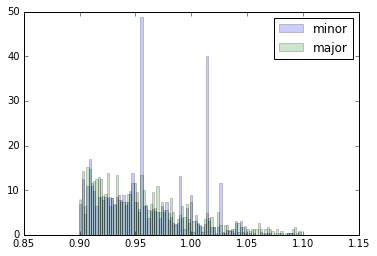

In [335]:
bins = np.linspace(.9,1.1,100)
plt.hist(g1[1]['cos_of_sum']*g1[1]['wmd_cos'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['cos_of_sum']*g2[1]['wmd_cos'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

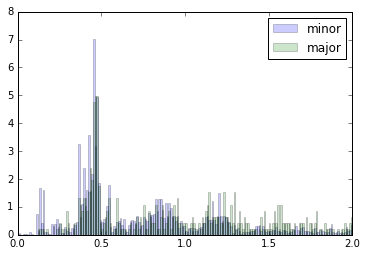

In [360]:
bins = np.linspace(.01,2.,200)
plt.hist(g1[1]['wmd_cos']*((g1[1]['s1_good']/(g1[1]['s1_bad']+epsilon))+(g1[1]['s2_good']/(g1[1]['s2_bad']+epsilon))),bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_cos']*((g2[1]['s1_good']/(g2[1]['s1_bad']+epsilon))+(g2[1]['s2_good']/(g2[1]['s2_bad']+epsilon))),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

### The following 4 clusters are split between 0 (normal) and 1-3 (lots of background rambling)

In [435]:
km = KMeans(n_clusters=4)
df_1s['good_bad_cluster'] = km.fit_predict(g1[1][['s1_good','s2_good','s1_bad','s2_bad']].values)
np.unique(df_1s['good_bad_cluster'])

array([0, 1, 2, 3], dtype=int32)

In [436]:
gb_min0,gb_min1,gb_min2,gb_min3 = df_1s.groupby('good_bad_cluster')

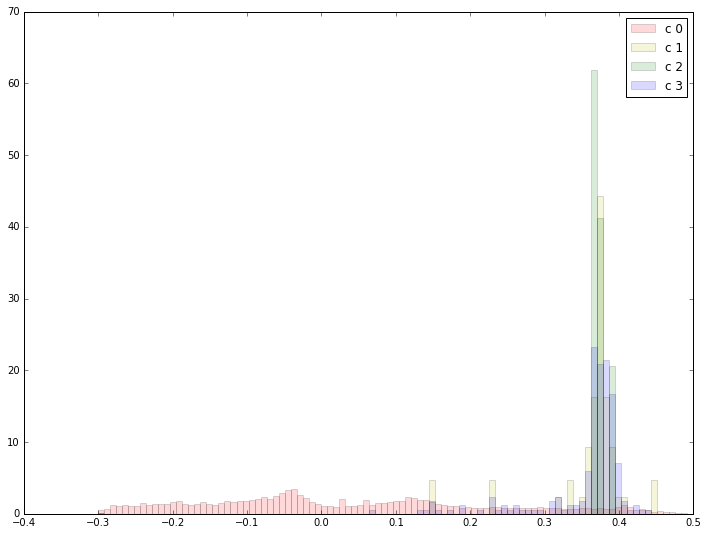

In [443]:
plt.figure(figsize=(12,9))
bins = np.linspace(-.3,.5,100)

plt.hist(gb_min0[1]['wmd_norm'],bins,alpha=.15,label='c 0',normed=True,color='r')
plt.hist(gb_min1[1]['wmd_norm'],bins,alpha=.15,label='c 1',normed=True,color='y')
plt.hist(gb_min2[1]['wmd_norm'],bins,alpha=.15,label='c 2',normed=True,color='g')
plt.hist(gb_min3[1]['wmd_norm'],bins,alpha=.15,label='c 3',normed=True,color='b')

plt.legend(loc='upper right')
plt.show()

In [458]:
gb_min0[1].shape[0]

51840

In [459]:
gb_min1[1].shape[0]+gb_min2[1].shape[0]+gb_min3[1].shape[0]

267

### getting to sum vector and differences

In [606]:
vector_df = pd.read_csv(training_set,header=None,
                        dtype={'error':np.int32,'one':str,'two':str},
                        na_filter=False)

vector_df.columns = ['error','one','two']
# because you fixed some errors above, so copy them into the new df
vector_df['error']=df['error']

In [607]:
epsilon = 1e-6

In [608]:
def sum_vectorizer(strings):
    
    s_1 = strings
    #s_1 = strings['one']
    #s_2 = strings['two']
    
    s1_features = s_1.split()
    #s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        

    # sum of word embeddings per string (small # epsilon if no items are in embeddings)
    # shape is [1,300] per string
    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    #S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    #if S2_.shape[0]==0:
    #    S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.sum(S1_,axis=0)).reshape([-1,1])
    #S2_ = np.asarray(np.sum(S2_,axis=0)).reshape([-1,1])
    
    #diff = S2_ - S1_
    
    #results_.extend(S1_)
    #results_.extend(S2_)
    #for i in range(S1_.shape[0]):
    #    print(S1_[i])

    
    #return diff
    return S1_

In [609]:
for i in range(300):
    vector_df['{}'.format(i+1)] = None

In [610]:
columns = vector_df.columns[3:]

### difference between both strings' sum vectors (sum of word vectors in the string)

In [611]:
temp = list(zip(*vector_df['one'].map(sum_vectorizer)))

In [612]:
temp2 = list(zip(*vector_df['two'].map(sum_vectorizer)))

In [613]:
temp3 = list(np.asarray(temp2)-np.asarray(temp))

In [614]:
for i, c in enumerate(columns): 
    vector_df[c] = temp3[i]

In [615]:
sums = vector_df.ix[:,3:].apply(sum,axis=1)

In [616]:
vector_df['sums'] = sums

In [618]:
vector_df['wmd_cos'] = vector_df[['one','two']].apply(WMD_cosine,axis=1)

In [619]:
X = vector_df[['wmd_cos','sums']]
Y = vector_df['error']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [621]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [622]:
rf.score(X_test,y_test)

0.73759433365656224

In [ ]:
# already fixed places where sums = 0 above in df
# deleted cells where i confirmed this here

## cluster by difference vector
### this ends up mostly finding instances of long strings of rambling changed to 'background conversation'

In [626]:
vector_df['cosine'] = vector_df[['one','two']].apply(cos_getter,axis=1)
vector_df['len1'] = map(len,vector_df['one'].values)
vector_df['len2'] = map(len,vector_df['two'].values)
vector_df['wmd_cos'] = vector_df[['one','two']].apply(WMD_cosine,axis=1)
vector_df['error'].loc[vector_df['len2']==0] = 1
vector_df['s1_good'] = vector_df['one'].apply(in_vocab)
vector_df['s2_good'] = vector_df['two'].apply(in_vocab)
vector_df['s1_bad'] = vector_df['one'].apply(out_of_vocab)
vector_df['s2_bad'] = vector_df['two'].apply(out_of_vocab)
vector_df['euclidean'] = vector_df[['one','two']].apply(euc_getter,axis=1)
vector_df['wmd_norm'] = vector_df['wmd_cos']-vector_df['wmd_cos'].mean()
vector_df['cos_norm'] = vector_df['cosine']-vector_df['cosine'].mean()
vector_df['euc_norm'] = vector_df['euclidean']-vector_df['euclidean'].mean()

In [627]:
km = KMeans(n_clusters=2)
vector_df['sum_clusters'] = km.fit_predict(vector_df[['{}'.format(i) for i in range(1,300)]].values)
np.unique(vector_df['sum_clusters'])

array([0, 1], dtype=int32)

In [628]:
c0,c1 = vector_df.groupby('sum_clusters')#,c2,c3,c4,c5,c6 

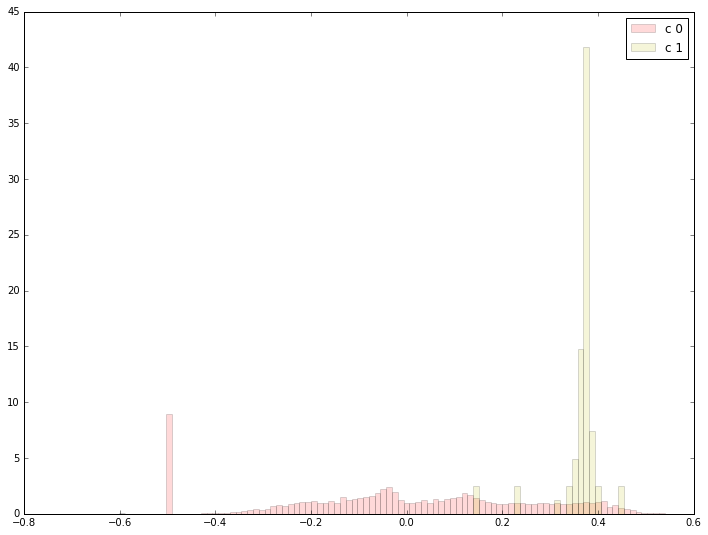

In [639]:
plt.figure(figsize=(12,9))
bins = np.linspace(-.6,.6,100)

plt.hist(c0[1]['wmd_norm'],bins,alpha=.15,label='c 0',normed=True,color='r')
plt.hist(c1[1]['wmd_norm'],bins,alpha=.15,label='c 1',normed=True,color='y')
#plt.hist(c2[1]['wmd_norm'],bins,alpha=.15,label='c 2',normed=True,color='g')
#plt.hist(c3[1]['wmd_norm'],bins,alpha=.15,label='c 3',normed=True,color='b')
#plt.hist(c4[1]['wmd_norm'],bins,alpha=.15,label='c 4',normed=True,color='c')
#plt.hist(c5[1]['wmd_norm'],bins,alpha=.15,label='c 5',normed=True,color='m')
#plt.hist(c6[1]['wmd_norm'],bins,alpha=.15,label='c 6',normed=True,color='k')


plt.legend(loc='upper right')
plt.show()

In [641]:
print(c0[1].shape[0])
print(c1[1].shape[0])

71807
67


#### yes the difference is clear but there are so few of them anyway
- dropping them

In [642]:
#c1[1] # background conversation

In [644]:
vector_df,_ = vector_df.groupby('sum_clusters')

In [685]:
vector_df=vector_df[1]

In [686]:
vector_df

,error,one,two,1,2,3,4,5,6,7,...,len2,s1_good,s2_good,s1_bad,s2_bad,euclidean,wmd_norm,cos_norm,euc_norm,sum_clusters
0,1,zone and,zone,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4,1,1,1,0,0.000000,-0.084544,-0.408930,-1.672531,0
1,2,zigbee 2,zigbee too,0.022949,0.237305,-0.086182,0.078613,-0.065430,0.141350,0.088867,...,10,1,1,1,1,2.888256,-0.029477,0.536328,1.215725,0
2,2,zero,four zero,0.085938,-0.072754,0.016724,0.085449,0.249023,-0.221680,-0.091309,...,9,1,2,0,0,1.513861,-0.091942,-0.260598,-0.158671,0
3,2,zappos is ideal,zappos' deal,0.193146,0.344849,-0.065918,-0.094604,0.125488,-0.224609,-0.213867,...,12,2,1,1,1,2.928596,0.091777,0.484339,1.256065,0
4,1,zapples,zappos,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6,0,0,1,1,0.000000,-0.502105,-0.408930,-1.672531,0
5,2,yuper,uper,0.005218,-0.025514,0.040038,0.106933,0.018187,-0.112306,-0.153321,...,4,0,1,1,0,1.660486,0.267095,0.678339,-0.012045,0
6,2,yup are,aren't,-0.257324,-0.184082,0.072266,-0.090820,-0.064453,-0.131348,-0.112427,...,6,2,1,0,0,2.237954,0.104786,0.049725,0.565423,0
7,2,y,sheeky,0.115724,-0.061278,-0.151366,-0.139647,-0.001830,-0.085936,-0.063964,...,6,1,0,0,1,2.761908,0.305407,0.563381,1.089376,0
8,1,you,you to,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6,1,1,0,1,0.000000,-0.087880,-0.408930,-1.672531,0
9,2,you,you that,-0.015747,-0.028320,0.083496,0.050293,-0.110352,0.031738,-0.014221,...,8,1,2,0,0,1.173538,-0.130880,-0.316132,-0.498994,0


### one more level deep; clustering on the majority group only

In [657]:
km = KMeans(n_clusters=5)
c0[1]['new_sum_clusters'] = km.fit_predict(c0[1][['{}'.format(i) for i in range(1,300)]].values)
np.unique(c0[1]['new_sum_clusters'])

array([0, 1, 2, 3, 4], dtype=int32)

In [658]:
nc0,nc1,nc2,nc3,nc4 = c0[1].groupby('new_sum_clusters')#,nc5

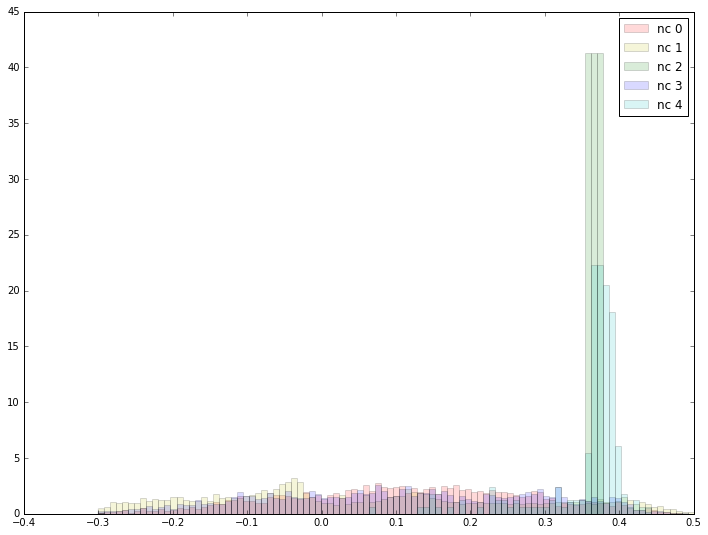

In [666]:
plt.figure(figsize=(12,9))
bins = np.linspace(-.3,.5,100)

plt.hist(nc0[1]['wmd_norm'],bins,alpha=.15,label='nc 0',normed=True,color='r')
plt.hist(nc1[1]['wmd_norm'],bins,alpha=.15,label='nc 1',normed=True,color='y')
plt.hist(nc2[1]['wmd_norm'],bins,alpha=.15,label='nc 2',normed=True,color='g')
plt.hist(nc3[1]['wmd_norm'],bins,alpha=.15,label='nc 3',normed=True,color='b')
plt.hist(nc4[1]['wmd_norm'],bins,alpha=.15,label='nc 4',normed=True,color='c')
#plt.hist(nc5[1]['wmd_norm'],bins,alpha=.15,label='nc 5',normed=True,color='m')


plt.legend(loc='upper right')
plt.show()

### more of the same

In [676]:
nc0[1].shape[0]+nc1[1].shape[0]+nc3[1].shape[0]

71599

In [677]:
nc2[1].shape[0]+nc4[1].shape[0]

208

In [673]:
keep_indices = np.union1d(nc0[1].index,nc1[1].index)
keep_indices = np.union1d(keep_indices,nc3[1].index)

In [675]:
keep_indices.shape

(71599,)

In [701]:
# these are likely the same as just using the sums as done below

### summing the elements of the resultant vector to get one number does mark a threshold of changes that involve lots of bg conversation to nothing or vice-versa
- potentially a handy segmenting boundary in deciding what to send to the model

In [700]:
vector_df.ix[vector_df['sums']>20][['error','one','two']]

,error,one,two
5135,2,section vary,session
12526,2,empowerment so reducing poverty this clickers ...,empowerment so
16396,2,0434 s good and then why don't you just zip it...,background conversation
16412,2,012047 s1 great okay we're gonna do one more t...,background conversation
16413,2,011434 s1 good and then why don't you just zip...,background conversation
19431,1,wdoc dot jobs 014348 s3 nailed it perfect 0143...,wdocjobs
19432,1,wdoc dot jobs 013481 s1 the right job right he...,wdocjobs
27832,1,safety 007117 s2 yep 007125 s1 so tell us what...,safety thing talk one little bit about
27976,1,s2 what would count as one basic discussing ma...,s
28231,1,roof roof roof roof they,woof woof woof woof it


In [699]:
vector_df.ix[vector_df['sums']<-20][['error','one','two']]

,error,one,two
1084,2,we're fine tracked we'll fast forward,no fire truck no grass blower
1219,2,weenie laughter,weenie laughter 022103 s1 there's the air forc...
1497,2,viable,viable do you want me to say more i can i don'...
8788,2,life their mom's are,life their mom's are you better you better you...
10078,2,influence and settlement plans,influence your circle of influence
12933,2,diving social,diving social engineering 019274 s i know beca...
13552,2,conversation,conversation 144316 s3 so what are you so what...
14052,2,center,center 02296 s2 awesome do you have anything e...
14934,2,background conversation,145381 s2 yeah i think it's great having someo...
14935,2,background conversation,141482 s1 you can follow me on instagram if yo...


In [705]:
small_sums = vector_df.ix[vector_df['sums']<-20][['error','one','two']].index

In [706]:
big_sums = vector_df.ix[vector_df['sums']>20][['error','one','two']].index

In [709]:
bad_indices = np.union1d(small_sums, big_sums)

In [710]:
bad_indices

array([ 1084,  1219,  1497,  5135,  8788, 10078, 12526, 12933, 13552,
       14052, 14934, 14935, 14936, 14950, 14956, 14967, 14968, 14970,
       14975, 14976, 14978, 14983, 15409, 16340, 16396, 16412, 16413,
       16428, 19431, 19432, 27832, 27976, 28231, 30577, 33242, 35734,
       35736, 36505, 37627, 37887, 39126, 43051, 45067, 45202, 46353,
       46708, 48253, 48254, 48982, 50767, 51447, 51840, 51845, 52451,
       52554, 52575, 52600, 52636, 52870, 53043, 53058, 53133, 53206,
       53255, 53256, 53380, 53398, 53596, 53753, 54009, 54048, 54452,
       54634, 54840, 54854, 54880, 54901, 55049, 55058, 55074, 55090,
       55120, 55126, 55141, 55154, 55557, 55578, 55732, 55733, 55817,
       55895, 55963, 55984, 56033, 56136, 56273, 56300, 56368, 56532,
       56576, 56612, 56640, 56678, 56713, 56729, 56757, 56785, 56803,
       57018, 57019, 57059, 57090, 57148, 57294, 57306, 57372, 57419,
       57436, 57438, 57439, 57556, 59628, 60577, 61220, 62149, 62170,
       64895, 65301,

In [717]:
# ones i already deleted after first clustering on sums
prior_indices = np.setdiff1d(range(71807),vector_df.index)

In [718]:
all_bad_indices = np.union1d(bad_indices,prior_indices)
good_indices = np.setdiff1d(range(71874),all_bad_indices)

In [720]:
vector_df = vector_df.ix[good_indices]

In [721]:
vector_df

,error,one,two,1,2,3,4,5,6,7,...,len2,s1_good,s2_good,s1_bad,s2_bad,euclidean,wmd_norm,cos_norm,euc_norm,sum_clusters
0,1,zone and,zone,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4,1,1,1,0,0.000000,-0.084544,-0.408930,-1.672531,0
1,2,zigbee 2,zigbee too,0.022949,0.237305,-0.086182,0.078613,-0.065430,0.141350,0.088867,...,10,1,1,1,1,2.888256,-0.029477,0.536328,1.215725,0
2,2,zero,four zero,0.085938,-0.072754,0.016724,0.085449,0.249023,-0.221680,-0.091309,...,9,1,2,0,0,1.513861,-0.091942,-0.260598,-0.158671,0
3,2,zappos is ideal,zappos' deal,0.193146,0.344849,-0.065918,-0.094604,0.125488,-0.224609,-0.213867,...,12,2,1,1,1,2.928596,0.091777,0.484339,1.256065,0
4,1,zapples,zappos,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6,0,0,1,1,0.000000,-0.502105,-0.408930,-1.672531,0
5,2,yuper,uper,0.005218,-0.025514,0.040038,0.106933,0.018187,-0.112306,-0.153321,...,4,0,1,1,0,1.660486,0.267095,0.678339,-0.012045,0
6,2,yup are,aren't,-0.257324,-0.184082,0.072266,-0.090820,-0.064453,-0.131348,-0.112427,...,6,2,1,0,0,2.237954,0.104786,0.049725,0.565423,0
7,2,y,sheeky,0.115724,-0.061278,-0.151366,-0.139647,-0.001830,-0.085936,-0.063964,...,6,1,0,0,1,2.761908,0.305407,0.563381,1.089376,0
8,1,you,you to,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6,1,1,0,1,0.000000,-0.087880,-0.408930,-1.672531,0
9,2,you,you that,-0.015747,-0.028320,0.083496,0.050293,-0.110352,0.031738,-0.014221,...,8,1,2,0,0,1.173538,-0.130880,-0.316132,-0.498994,0


### $$

In [764]:
df = df.ix[good_indices]

In [772]:
write_out = df[['error','one','two']]

In [774]:
write_out.to_csv('/Users/Rutherford/Desktop/clean_11_10.csv',header=None,index=None)

In [776]:
from scipy.spatial.distance import chebyshev, correlation

In [827]:
def cheb_getter(strings):
    s_1 = strings['one']
    s_2 = strings['two']
        
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        

    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])

    return chebyshev(S1_,S2_)


In [829]:
def corr_getter(strings):
    s_1 = strings['one']
    s_2 = strings['two']
        
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        


    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])

    return correlation(S1_,S2_)


In [850]:
def sum_corr_getter(strings):
    s_1 = strings['one']
    s_2 = strings['two']
        
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        


    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.sum(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.sum(S2_,axis=0)).reshape([-1,1])

    return correlation(S1_,S2_)


In [828]:
df['chebyshev'] = df.apply(cheb_getter,axis=1)

In [830]:
df['correlation'] = df.apply(corr_getter,axis=1)

In [851]:
df['sum_correlation'] = df.apply(sum_corr_getter,axis=1)

In [852]:
mins,majs = df.groupby('error')

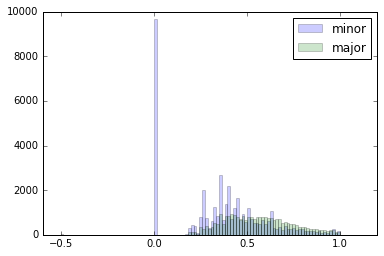

In [795]:
# with sum in the vector calc
bins = np.linspace(-.5,1,100)
plt.hist(mins[1]['chebyshev'],bins,alpha=.2,label='minor')
plt.hist(majs[1]['chebyshev'],bins,alpha=.2,label='major')
plt.legend(loc='upper right');

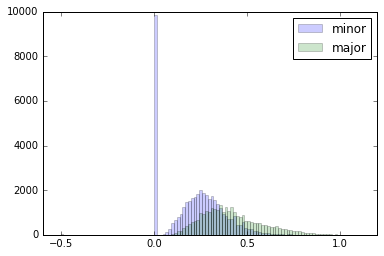

In [832]:
# with mean in the vector calc
bins = np.linspace(-.5,1,100)
plt.hist(mins[1]['chebyshev'],bins,alpha=.2,label='minor')
plt.hist(majs[1]['chebyshev'],bins,alpha=.2,label='major')
plt.legend(loc='upper right');

In [796]:
# what would happen if you just dropped these and made the model deal with only the others
#df[df['chebyshev']<.01]

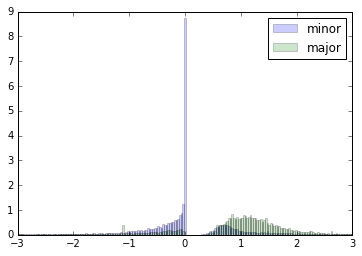

In [833]:
bins = np.linspace(-3,3,200)
plt.hist((mins[1]['chebyshev']+epsilon)*(mins[1]['cosine']+epsilon)/(mins[1]['wmd_norm']+epsilon),bins,alpha=.2,label='minor',normed=True)
plt.hist((majs[1]['chebyshev']+epsilon)*(majs[1]['cosine']+epsilon)/(majs[1]['wmd_norm']+epsilon),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right');

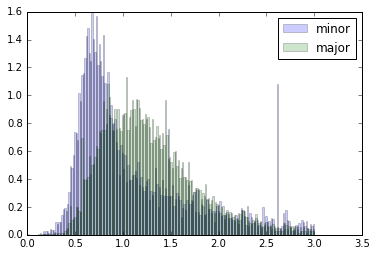

In [834]:
bins = np.linspace(.01,3,200)
plt.hist((mins[1]['chebyshev']+epsilon)*(mins[1]['cosine']+epsilon)/(mins[1]['wmd_norm']+epsilon),bins,alpha=.2,label='minor',normed=True)
plt.hist((majs[1]['chebyshev']+epsilon)*(majs[1]['cosine']+epsilon)/(majs[1]['wmd_norm']+epsilon),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right');

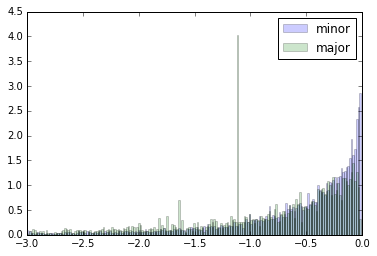

In [835]:
bins = np.linspace(-3,-.01,200)
plt.hist((mins[1]['chebyshev']+epsilon)*(mins[1]['cosine']+epsilon)/(mins[1]['wmd_norm']+epsilon),bins,alpha=.2,label='minor',normed=True)
plt.hist((majs[1]['chebyshev']+epsilon)*(majs[1]['cosine']+epsilon)/(majs[1]['wmd_norm']+epsilon),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right');

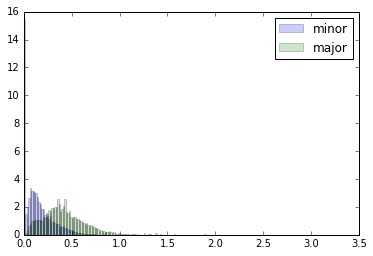

In [840]:
bins = np.linspace(0,3,200)
#plt.hist((mins[1]['correlation']+epsilon)*(mins[1]['chebyshev']+epsilon)/(mins[1]['wmd_cos']+epsilon),bins,alpha=.2,label='minor',normed=True)
#plt.hist((majs[1]['correlation']+epsilon)*(majs[1]['chebyshev']+epsilon)/(majs[1]['wmd_cos']+epsilon),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right');

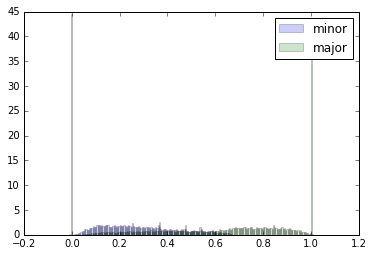

In [844]:
bins = np.linspace(-.01,1.01,200)
plt.hist((mins[1]['correlation']),bins,alpha=.2,label='minor',normed=True)
plt.hist((majs[1]['correlation']),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right');

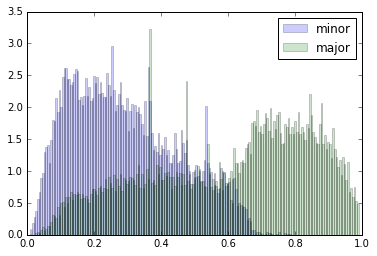

In [848]:
bins = np.linspace(0.01,.99,200)
plt.hist((mins[1]['correlation']),bins,alpha=.2,label='minor',normed=True)
plt.hist((majs[1]['correlation']),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right');

In [853]:
#df.ix[(df['correlation']<.6)&(df['error']==2)]

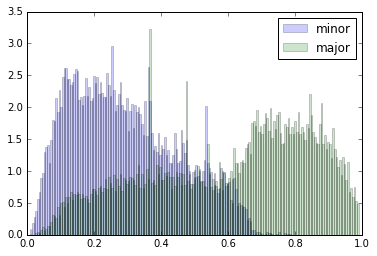

In [855]:
bins = np.linspace(.01,.99,200)
plt.hist((mins[1]['sum_correlation']),bins,alpha=.2,label='minor',normed=True)
plt.hist((majs[1]['sum_correlation']),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right');

In [929]:
df.head()

,error,one,two,cosine,len1,len2,wmd_cos,s1_good,s2_good,s1_bad,s2_bad,euclidean,wmd_norm,cos_norm,euc_norm,wmd_times_cos,cos_of_sum,chebyshev,correlation,sum_correlation
0,1,zone and,zone,0.000000e+00,8,4,4.175405e-01,1,1,1,0,0.000000,-0.084538,-0.408930,-1.672534,0.034570,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
1,2,zigbee 2,zigbee too,9.452572e-01,8,10,4.726050e-01,1,1,1,1,2.888256,-0.029473,0.536328,1.215722,-0.015807,9.452572e-01,0.503906,9.441914e-01,9.441914e-01
2,2,zero,four zero,1.483317e-01,4,9,4.101423e-01,1,2,0,0,1.513861,-0.091936,-0.260598,-0.158673,0.023958,1.483317e-01,0.295410,1.493696e-01,1.493696e-01
3,2,zappos is ideal,zappos' deal,8.932686e-01,15,12,5.938654e-01,2,1,1,1,2.928596,0.091787,0.484339,1.256063,0.044456,8.932686e-01,0.440552,8.944399e-01,8.944399e-01
4,1,zapples,zappos,3.330669e-16,7,6,1.110112e-16,0,0,1,1,0.000000,-0.502078,-0.408930,-1.672534,0.205315,3.330669e-16,0.000000,2.220446e-16,2.220446e-16


In [858]:
sum(df['correlation']!=df['sum_correlation'])

10393

In [868]:
unequal_minor = df.ix[(df['correlation']!=df['sum_correlation'])&(df['error']==1)]['correlation']
unequal_major = df.ix[(df['correlation']!=df['sum_correlation'])&(df['error']==2)]['correlation']

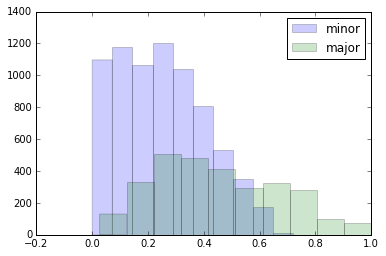

In [873]:
plt.hist(unequal_minor,alpha=.2,label='minor')
plt.hist(unequal_major,alpha=.2,label='major')
plt.legend(loc='upper right');

In [938]:
df = df.reset_index().drop('index',axis=1)

In [939]:
np.random.seed(31)
indices = df.iloc[np.random.permutation(len(df))].index.values

In [940]:
X = df.loc[indices][[3,4,5,6,7,8,9,10,11,16,17,18,19]].values
Y = df.loc[indices][[0]].values

X_in = np.asarray(df.loc[indices][[1,2]],dtype=str)
Y_in = df.loc[indices][[0]].values

In [941]:
y_list = []
for i, label in enumerate(Y):
    if label == 2:
        label = 1
        y_list.append(np.insert(label,0,0))
    elif label == 1:
        y_list.append(np.insert(label,1,0))
    else:
        raise ValueError("Y label must be either 1 (minor) or                                     2 (major). Problem at index ", indices[i])
Y = np.asarray(y_list)

In [942]:
indices.tofile('/Users/Rutherford/Desktop/second numpy write out/indices')
X.tofile('/Users/Rutherford/Desktop/second numpy write out/X')
Y.tofile('/Users/Rutherford/Desktop/second numpy write out/Y')
X_in.tofile('/Users/Rutherford/Desktop/second numpy write out/X_in')
Y_in.tofile('/Users/Rutherford/Desktop/second numpy write out/Y_in')

In [943]:
X_in

array([["company's", "companies'"],
       ['job', "job and so that's just"],
       ['drive', 'drives'],
       ..., 
       ['say you', 'say that you'],
       ["six percent you'll", '6 you'],
       ['02302', '0235']], 
      dtype='|S64')

In [944]:
df.columns[[3,4,5,6,7,8,9,10,11,16,17,18,19]]

Index([u'cosine', u'len1', u'len2', u'wmd_cos', u's1_good', u's2_good',
       u's1_bad', u's2_bad', u'euclidean', u'cos_of_sum', u'chebyshev',
       u'correlation', u'sum_correlation'],
      dtype='object')